In [1]:
import os
import numpy as np

import functions.functions as fc
import functions.nifti_functions as nfc

import project_images_loader as pil
import matplotlib.pyplot as plt  
import cv2 as cv

from scipy import ndimage


In [2]:
def draw_face(img_shape, eye_flat=False, eye_radius=10, mouth_radius_up=40, mouth_radius_down=40):
    mask_2D = np.zeros(img_shape, np.uint8)
    center = np.array([img_shape[1]//2, img_shape[0]//2])

    # mouth
    mouth_up = 10
    mouth_down = 0

    mouth_center_up = center + np.array([0,mouth_up])
    mouth_center_down = center + np.array([0,mouth_down])

    mask_2D = fc.draw_circle(mask_2D, (mouth_center_up, mouth_radius_up), color=(255,0,0))
    mask_2D = fc.draw_circle(mask_2D, (mouth_center_down, mouth_radius_down), color=(0,255,0))

    # eye_flat
    if eye_flat:
        eye_sepatarion = 50
        eye_up = 20

        eyer_center = center + np.array([eye_sepatarion//2,0]) - np.array([0,eye_up])
        eyel_center = center - np.array([eye_sepatarion//2,0]) - np.array([0,eye_up])

        eye_flat_roi = eyel_center[0]-eye_radius, eyel_center[1]-eye_radius//4, eyel_center[0]+eye_radius, eyel_center[1]+eye_radius//4

        mask_2D = fc.draw_circle(mask_2D, (eyer_center, eye_radius), color=(255,255,255))[...,0]
        mask_2D = fc.draw_roi(mask_2D, eye_flat_roi, color=(255,255,255))[...,0]

    # eyes normal
    else:
        eye_sepatarion = 50
        eye_up = 20

        eyer_center = center + np.array([eye_sepatarion//2,0]) - np.array([0,eye_up])
        eyel_center = center - np.array([eye_sepatarion//2,0]) - np.array([0,eye_up])

        mask_2D = fc.draw_circle(mask_2D, (eyer_center, eye_radius), color=(255,255,255))[...,0]
        mask_2D = fc.draw_circle(mask_2D, (eyel_center, eye_radius), color=(255,255,255))[...,0]

    return mask_2D


def apply_gaussian(img, k_size):
    if k_size <= 1:
        k_size = 3
    elif k_size % 2 == 0:
        k_size +=1
    return cv.GaussianBlur(img, (k_size, k_size), 0)


def generate_3D_face(img_shape, n_layers, eye_flat=False, eye_radius_max=10, mouth_radius_up_max=40, mouth_radius_down_max=40, gaussian=None, gaussian_limit=25):
    
    mask_3D = np.zeros((*img_shape, n_layers+1))

    i_max = n_layers // 2
    for i in range(i_max):
        eye_radius=int(eye_radius_max * i/i_max)
        mouth_radius_up=int(mouth_radius_up_max * i/i_max)
        mouth_radius_down=int(mouth_radius_down_max * i/i_max)

        mask_3D[:,:, i] = draw_face(img_shape, eye_flat=eye_flat, eye_radius=eye_radius, mouth_radius_up=mouth_radius_up, mouth_radius_down=mouth_radius_down)
        if gaussian is not None:
            k_size = int(i*gaussian)
            if k_size > gaussian_limit:
                k_size = gaussian_limit
            mask_3D[:,:, i] = apply_gaussian(mask_3D[:,:, i], k_size)
            
        mask_3D[:,:, -(i+1)] = mask_3D[:,:, i]


    mask_3D[:,:, i_max] = draw_face(img_shape, eye_flat=eye_flat, eye_radius=eye_radius_max, mouth_radius_up=mouth_radius_up_max, mouth_radius_down=mouth_radius_down_max)
    
    if gaussian is not None:
        mask_3D[:,:, i_max] = apply_gaussian(mask_3D[:,:, i_max], min(int(i_max*gaussian),gaussian_limit))
    
    return mask_3D



### load and erode brain mask

In [3]:
mask_volume, _ = pil.load_brain_mask(9999, 1, pil.FOLDER_REGISTERED)
img_gm_prob_label, img_wm_prob_label, img_csf_prob_label = pil.load_spm_labels(9999, 2, pil.FOLDER_REGISTERED, -1)

elemento_estructurante = np.ones((25,25,11))
mask_volume_erode = ndimage.binary_erosion(mask_volume, structure=elemento_estructurante).astype(mask_volume.dtype)


### create prob labels

In [4]:
div = 1
# obtain border csf
aa = np.ones((mask_volume.shape)) - (mask_volume_erode / div)
img_csf_border = img_csf_prob_label * aa

# create smiling face
mask_3D_1 = generate_3D_face((217, 181), 180, gaussian=0.2, gaussian_limit=25)/255
mask_3D_1 = np.fliplr(np.transpose(mask_3D_1, (1, 0, 2))) * mask_volume 

# creating new csf prob mask
new_img_csf_prob_label = np.clip(mask_3D_1 + img_csf_border, 0, 1)

# creating new wm and prob mask
bb = np.ones((mask_volume.shape))  - (mask_3D_1/div)
new_img_gm_prob_label = img_gm_prob_label *bb
new_img_wm_prob_label = img_wm_prob_label *bb

_, affine = pil.load_spm_labels(9999, 2, pil.FOLDER_REGISTERED, 3)
patient_path = pil.get_patient_path(9999, 2, pil.FOLDER_REGISTERED)

new_gm_path_name = os.path.join(patient_path, pil.NAME_SPM_PROB_LABEL.format(1))
new_wm_path_name = os.path.join(patient_path, pil.NAME_SPM_PROB_LABEL.format(2))
new_csf_path_name = os.path.join(patient_path, pil.NAME_SPM_PROB_LABEL.format(3))

nfc.save_nifit(new_img_gm_prob_label, affine, new_gm_path_name)
nfc.save_nifit(new_img_wm_prob_label, affine, new_wm_path_name)
nfc.save_nifit(new_img_csf_prob_label, affine, new_csf_path_name)





0.0
0.0
154627.43001322137


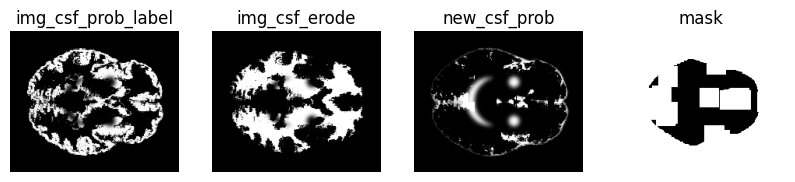

In [5]:
layer = 70
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
fc.imgshow_matplotlib("img_csf_prob_label", new_img_gm_prob_label[...,layer], subplot=axs[0])
fc.imgshow_matplotlib("img_csf_erode", new_img_wm_prob_label[...,layer], subplot=axs[1])
fc.imgshow_matplotlib("new_csf_prob", new_img_csf_prob_label[...,layer], subplot=axs[2])
fc.imgshow_matplotlib("mask", aa[...,layer], subplot=axs[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


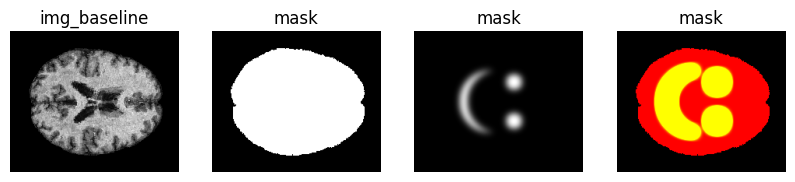

In [7]:
img_baseline, _ = pil.load_nsk_volume(9999, 1, pil.FOLDER_REGISTERED)
mask_volume, _ = pil.load_brain_mask(9999, 1, pil.FOLDER_REGISTERED)
mask_3D_1 = generate_3D_face((217, 181), 180, gaussian=0.5, gaussian_limit=25)

mask_3D_1 = np.fliplr(np.transpose(mask_3D_1, (1, 0, 2))) * mask_volume 


layer = 90
kk = np.zeros((*img_baseline.shape[:2], 3))
kk[...,0] = mask_volume[...,layer]
kk[...,1] = mask_3D_1[...,layer]

fig, axs = plt.subplots(1, 4, figsize=(10, 5))
fc.imgshow_matplotlib("img_baseline", img_baseline[...,layer], subplot=axs[0])
fc.imgshow_matplotlib("mask", mask_volume[...,layer], subplot=axs[1])
fc.imgshow_matplotlib("mask", mask_3D_1[...,layer], subplot=axs[2])
fc.imgshow_matplotlib("mask", kk, subplot=axs[3])


In [8]:

def show_layers():
    n_layers = 10
    mask_3D_1 = generate_3D_face((217, 181), n_layers, gaussian=4)
    mask_3D_2 = generate_3D_face((217, 181), n_layers, eye_flat=True, gaussian=4)

    for i in range(n_layers+1):
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        fc.imgshow_matplotlib("mask 1", mask_3D_1[..., i], subplot=axs[0])
        fc.imgshow_matplotlib("mask 2", mask_3D_2[..., i], subplot=axs[1])
        fig.suptitle(f"img {i+1} of {n_layers+1}")